![](../../header1.png)

# Mapping the Earth

Kevin Walchko

---

GPS gives us the location of our position anywhere on Earth (provided we can "see" the satellites). However, those coordinates are our location on a sphere and they are in degrees ... it would be better if we could convert them to a local coordinate in something more useful like meters.

## Local Tangent Plane

The first step is to define a plane at your current GPS location. The plane is defined such that it is tangent to the surface of a sphere.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/7/73/ECEF_ENU_Longitude_Latitude_relationships.svg/220px-ECEF_ENU_Longitude_Latitude_relationships.svg.png)

This is all well and good, but the Earth is not a sphere, it is an obleque shape where the equitorial radius of the Earth is larger than the polar radius. Said another way, the width from one side of the Earth to the other at the equator is larger than the width from the North to South pole. The reallity is the Earth is old and has gotten kind of fat around its equator ... it happens to everyone.

## Local Frames

- **NED:** North, East, Down. This is liked because all rotations about an axis (righthand rule) are seen as positive. The negative to this frame is down is posative since the z-axis points down. This is similar to the aerospace body frame seen on aircraft.
- **ENU:** East, North, Up. This is liked because up is up, but unlike NED, the positive direction for pitch and yaw are both counter clockwise which some don't like.

# References

- [Earth's ellisoid](https://en.wikipedia.org/wiki/Earth_ellipsoid)
- [World Geodetic System](https://en.wikipedia.org/wiki/World_Geodetic_System#A_new_World_Geodetic_System:_WGS_84)
- [World Magnetic Model](https://en.wikipedia.org/wiki/World_Magnetic_Model)
- [World Gravitational Model](https://en.wikipedia.org/wiki/Earth_Gravitational_Model)

In [197]:
import numpy as np
from numpy.linalg import norm
from numpy import arcsin, cos, sin, pi, sqrt, arcsin as asin, arctan2 as atan2
from matplotlib import pyplot as plt

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

In [191]:
# GPS locations for places on the Earth
lyon = (45.7597, 4.8422, 0) # (lat, lon, alt)
paris = (48.8567, 2.3508, 0)
newyork = (40.730610, -73.935242, 0)

In [192]:
deg2rad = np.pi/180
rad2deg = 180/np.pi

class WGS84:
    """
    WGS84 is used in GPS
    
    https://en.wikipedia.org/wiki/Earth_radius
    https://en.wikipedia.org/wiki/Earth_ellipsoid
    https://en.wikipedia.org/wiki/World_Geodetic_System#A_new_World_Geodetic_System:_WGS_84
    
    rf: inverse flattening
    f: flattening
    a: equitorial radius or semi-major axis [m]
    b: polar radius or semi-minor axis [m]
    e: eccentricity of Earth ellipsoid
    r: spherical radius [m]
    rotation_rate: Earth's rotation rate [seconds]
    """
    def __init__(self):
        self.rf = 298.257223563
        self.f = 1/self.rf
        self.a = 6378137.0
        self.b = self.a - self.a * self.f
        self.e = np.sqrt(1 - (self.b ** 2 / self.a ** 2))
        self.r = (2*self.a + self.b) / 3
        self.rotation_rate = 23*3600 + 56*60 + 4.09053
        
    def haversine(self, a, b):
        """
        Returns the haversine (or great circle) distance between
        2 GPS coordinates. This appears to work really well.
        
        a: (lat, lon) in deg
        b: (lat, lon) in deg
        """
        lat = b[0]*deg2rad
        # R = 6371008.8
        R = self.r
        dlat = (b[0] - a[0])*deg2rad
        dlon = (b[1] - a[1])*deg2rad
        m = sin(dlat*0.5)**2 + cos(a[0]*deg2rad) * cos(b[0]*deg2rad) * sin(dlon*0.5)**2
        return R*2*asin(min(1, sqrt(m)))
    
    def radius(self, lat):
        """
        Returns the geocentric radius based on WGS84
        
        lat: latitude in deg
        """
        a = self.a
        b = self.b
        lat = lat*deg2rad
        num = (a**2 * cos(lat))**2 + (b**2 * sin(lat))**2
        den = (a * cos(lat))**2 + (b * sin(lat))**2
        return sqrt(num / den)
    
    def llh2ecef(self, lla):
        """
        Geodetic coordinates are a type of curvilinear orthogonal coordinate 
        system used in geodesy based on a reference ellipsoid. They include 
        geodetic latitude (north/south) phi, longitude (east/west) lambda, and 
        ellipsoidal height h (also known as geodetic height). The triad 
        is also known as Earth ellipsoidal coordinates
        https://en.wikipedia.org/wiki/Geodetic_coordinates
        
        llh: latitude (phi), longitude(lambda), height (or altitude) (H) in [deg, deg, m]
        ecef: Earth Centered Earth Fixed in [m, m, m]
        
        ref: https://en.wikipedia.org/wiki/Geographic_coordinate_conversion
        """
        lat = lla[0] *deg2rad
        lon = lla[1] * deg2rad
        
        if len(lla) == 2:
            H = 0
        else:
            H = lla[2]
            
        e2 = wgs.e**2
        n = wgs.a / sqrt(1.0 - e2 * sin(lat)**2)
        
        x = (n + H) * cos(lat) * cos(lon)
        y = (n + H) * cos(lat) * sin(lon)
        z = ((1 - e2) * n + H) * sin(lat)
        return np.array([x, y, z])
    
    def ecef2llh(self, ecef):
        """
        llh: latitude (phi), longitude(lambda), height (or altitude) (H) in [deg, deg, m]
        ecef: Earth Centered Earth Fixed in [m, m, m]
        
        https://en.wikipedia.org/wiki/Geographic_coordinate_conversion#From_ECEF_to_geodetic_coordinates
        """
        x,y,z = ecef

        a = self.a
        a2 = self.a**2
        b2 = self.b**2
        e2 = self.e**2
        er2 = (a**2 - b2) / b2
        z2 = z**2
        
        p2 = x**2 + y**2
        p = sqrt(p2)
        
        F = 54 * b2 * z2
        G = p2 + (1-e2)*z2 - e2*(a2-b2)
        c = (e2**2 * F * p2) / G**3
        s = pow(1+c+sqrt(c**2 + 2*c), 1/3)
        k = s+1+1/s
        P = F / (3 * k**2 * G**2)
        Q = sqrt(1+ 2* e2**2 * P)
        ro = -(P * e2 * p) / (1 + Q) + sqrt(0.5*a2 * (1+1/Q) - P*(1-e2)*z2 / (Q+Q**2) - 0.5 * P *p2)
        U = sqrt((p-e2*ro)**2 + z2)
        V = sqrt((p-e2*ro)**2 + (1-e2) * z2)
        zo = b2*z / (a*V)
        h = U * (1 - b2 / (a*V))
        lat = arctan2(z+er2*zo, p) *rad2deg
        lon = arctan2(y, x) * rad2deg
        
        return np.array([lat, lon, h])
    
    
# or NavigationFrame?
class LocalFrames:
    """
    Converts between ENU <-> ECEF <-> NED
    
    All of these frames are useful for navigation either globally (ECEF)
    or locally (NED, ENU).
    
    Geodetic coordinates: latitude, longitude which are reported by GPS
    
    ECEF: a geocentric coordinate system, which is just a 3D cartesian 
          spatial reference system with the origin at the Earth's 
          center of mass.
          
    ref: https://en.wikipedia.org/wiki/Earth-centered,_Earth-fixed_coordinate_system
    """
    
    def __init__(self, llref):
        """
        llref: (lat, lon) of reference frame origin, a third element
                altitude can also be included (lat, lon, alt) otherwise
                the altitude is assumed to be 0.
        """
        self.latr = llref[0]*deg2rad
        self.lonr = llref[1]*deg2rad
        self.ecefr = self.__llh2ecef(llref)
        
    def __llh2ecef(self, lla):
        """
        Geodetic coordinates are a type of curvilinear orthogonal coordinate 
        system used in geodesy based on a reference ellipsoid. They include 
        geodetic latitude (north/south) phi, longitude (east/west) lambda, and 
        ellipsoidal height h (also known as geodetic height). The triad 
        is also known as Earth ellipsoidal coordinates
        https://en.wikipedia.org/wiki/Geodetic_coordinates
        
        llh: latitude (phi), longitude(lambda), height (or altitude) (H) in [deg, deg, m]
        ecef: Earth Centered Earth Fixed in [m, m, m]
        
        ref: https://en.wikipedia.org/wiki/Geographic_coordinate_conversion
        """
        lat = lla[0] *deg2rad
        lon = lla[1] * deg2rad
        
        if len(lla) == 2:
            H = 0
        else:
            H = lla[2]
            
        a  = 6378137.0        # Semi major axis of Earth [m]
        e2 = 0.00669437999014 # Eccentricity of Earth ellipsoid squared
        n = a / sqrt(1.0 - e2 * sin(lat)**2)
        
        x = (n + H) * cos(lat) * cos(lon)
        y = (n + H) * cos(lat) * sin(lon)
        z = ((1 - e2) * n + H) * sin(lat)
        
        return np.array([x, y, z])
        
    def ecef2enu(self, ecef):
        """
        ref: https://en.wikipedia.org/wiki/Geographic_coordinate_conversion#From_ECEF_to_ENU
        """
        lat = self.latr
        lon = self.lonr
        ref = self.ecefr
        
        slat = sin(lat); clat = cos(lat)
        slon = sin(lon); clon = cos(lon)
        
        # FIXME: get rid of trig calls
        r = np.array([
            [-sin(lon),                    cos(lon),        0],
            [-sin(lat)*cos(lon), -sin(lat)*sin(lon), cos(lat)],
            [ cos(lat)*cos(lon),  cos(lat)*sin(lon), sin(lat)]
        ])
        
        return r.dot(ecef - ref)
    
    def enu2ecef(self, enu):
        """
        ref: https://en.wikipedia.org/wiki/Geographic_coordinate_conversion#From_ENU_to_ECEF
        """
        lat = self.latr
        lon = self.lonr
        ref = self.ecefr
        
        slat = sin(lat); clat = cos(lat)
        slon = sin(lon); clon = cos(lon)
        
        r = np.array([
            [-slon, -slat*clon, clat*clon],
            [ clat, -slat*slon, clat*slon],
            [    0,       clat,      slat]
        ])
        
        return r.dot(enu) + ref
    
    def ecef2ned(self, ecef):
        """
        llh: latitude (phi), longitude(lambda), height (or altitude) (H) in [deg, deg, m]
        ecef: Earth Centered Earth Fixed in [m, m, m]
        ned: North, East, Down in [m, m, m]
        
        ref: https://en.wikipedia.org/wiki/Local_tangent_plane_coordinates#Local_north,_east,_down_(NED)_coordinates
        """
        lat = self.latr
        lon = self.lonr
        ref = self.ecefr
        
        slat = sin(lat); clat = cos(lat)
        slon = sin(lon); clon = cos(lon)
        
        #     R = np.array(
        #         [
        #             [-np.sin(lat)*np.cos(lon), -np.sin(lat)*np.sin(lon), np.cos(lat)],
        #             [-np.sin(lon), np.cos(lon), 0],
        #             [-np.cos(lat)*np.cos(lon), -np.cos(lat)*np.sin(lon), -np.sin(lat)]
        #         ]
        #     )
        
        # FIXME: get rid of transpose
        r = np.array([
            [-slat*clon, -slon, -clat*clon],
            [-slat*slon,  clon, -clat*slon],
            [      clat,     0,      -slat]
        ]).T
        
        return r.dot(ecef - ref)
    
    def ned2ecef(self, ned):
        """
        llh: latitude (phi), longitude(lambda), height (or altitude) (H) in [deg, deg, m]
        ecef: Earth Centered Earth Fixed in [m, m, m]
        ned: North, East, Down in [m, m, m]
        
        ref: https://en.wikipedia.org/wiki/Local_tangent_plane_coordinates#Local_north,_east,_down_(NED)_coordinates
        """
        lat = self.latr
        lon = self.lonr
        ref = self.ecefr
        
        slat = sin(lat); clat = cos(lat)
        slon = sin(lon); clon = cos(lon)
        
        r = np.array([
            [-slat*clon, -slon, -clat*clon],
            [-slat*slon,  clon, -clat*slon],
            [      clat,     0,      -slat]
        ])
        
        return r.dot(ned) + ref
        

In [193]:
wgs = WGS84()

Max differnce: 21.38 km


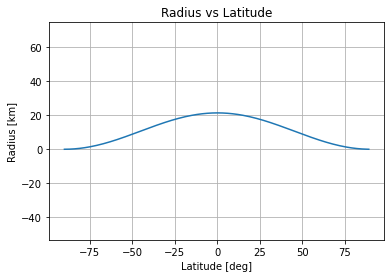

In [214]:
lats = np.arange(-90,90,1)

print(f"Max differnce: {(wgs.radius(0) - wgs.radius(90))/1000:.2f} km")

# not thrilled, but in order to plot clearly, I subtracted
# off the radius at the pole. Thus you can see it better
earth_r = (wgs.radius(lats) - wgs.radius(90)) / 1000

plt.plot(lats,earth_r);
plt.axis('equal')
# plt.ticklabel_format(style='plain')    # to prevent scientific notation
plt.ylabel("Radius [km]")
plt.xlabel("Latitude [deg]")
plt.title(f"Radius vs Latitude")
plt.grid(True);

In [185]:
pecef = wgs.llh2ecef(paris)

fr = Frames(paris)
enu = fr.ecef2enu(pecef)
pecef2 = fr.enu2ecef(enu)
paris2 = wgs.ecef2llh(pecef2)
print("ECEF:", pecef, pecef2)
print("ECEF diff:", pecef - pecef2)
print("--------------")
print("lla:", paris, paris2)
print("lla diff:", paris - paris2)

ECEF: [4200910.643  172456.785 4780088.659] [4200910.643  172456.785 4780088.659]
ECEF diff: [0. 0. 0.]
--------------
lla: (48.8567, 2.3508, 0) [48.857  2.351  0.   ]
lla diff: [0. 0. 0.]


In [186]:
pecef = wgs.llh2ecef(paris)
pecef += [100,200,300]

fr = LocalFrames(paris)
enu = fr.ecef2enu(pecef)
pecef2 = fr.enu2ecef(enu)

print("Delta:", norm([100,200,300]))
print("ECEF:", pecef, pecef2)
print("ENU", enu, norm(enu))

Delta: 374.16573867739413
ECEF: [4201010.643  172656.785 4780388.659] [4201010.643  172589.999 4780388.659]
ENU [195.73  115.962 297.056] 374.16573867420504


In [194]:
# google says 5,834 km New York to Paris
print(f"{wgs.haversine(newyork, paris) / 1000:.1f}")

5831.2


In [196]:
# this should match our equatorial and polar radius of the Earth equation
# said another way, the difference should be 0 if they match (or really small)
print("radius(90) diff:", wgs.radius(90) - wgs.b)
print("radius(0) diff", wgs.radius(0) - wgs.a)

radius(90) diff: 0.0
radius(0) diff 0.0
